In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

In [2]:
from rxitect.scorers.a2ascore import Predictor
from rdkit.Chem import MolFromSmiles

In [3]:
drugex_base_smiles = pd.Series(pd.read_csv("../data/drugex_selfies_base_80k.csv", header=None)[0]).to_list()

In [4]:
drugex_base_smiles = list(set(drugex_base_smiles))

In [8]:
mols = [MolFromSmiles(smi) for smi in drugex_base_smiles]

In [6]:
enhanced_fps = Predictor.calc_fp(mols=mols)

In [7]:
a2a = Predictor(path="../models/RF_REG_CHEMBL251.pkg")
a2ascore_preds = a2a(enhanced_fps)
a2ascore_preds = torch.from_numpy(a2ascore_preds.astype(np.float32))
a2ascore_preds = (a2ascore_preds / 8.8).clamp(0, 1)

<AxesSubplot: ylabel='Density'>

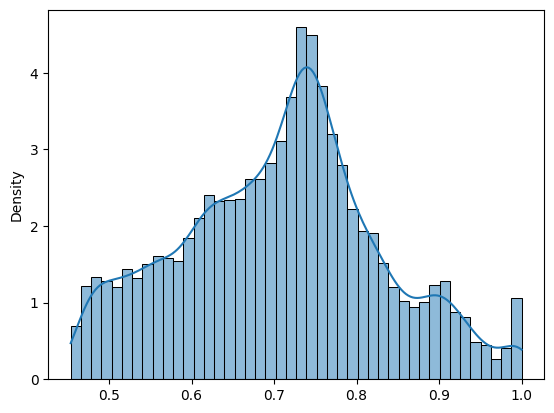

In [9]:
sns.histplot(a2ascore_preds, stat="density", kde=True)

In [10]:
a1 = Predictor(path="../models/RF_REG_CHEMBL226.pkg")
a1_score_preds = a1(enhanced_fps)
a1score_preds = torch.from_numpy(a1_score_preds.astype(np.float32))
a1score_preds = (a1score_preds / 8.6).clamp(0, 1)

<AxesSubplot: ylabel='Density'>

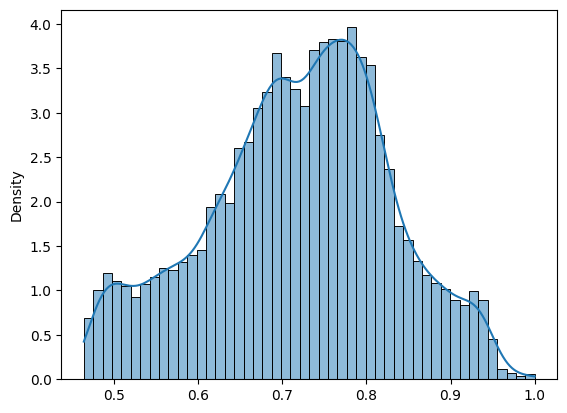

In [11]:
sns.histplot(a1score_preds, stat="density", kde=True)

In [12]:
herg = Predictor(path="../models/RF_REG_CHEMBL240.pkg")
herg_score_preds = herg(enhanced_fps)
herg_preds = torch.from_numpy(herg_score_preds.astype(np.float32))
herg_preds = (herg_preds / 7.4).clamp(0, 1)

<AxesSubplot: ylabel='Density'>

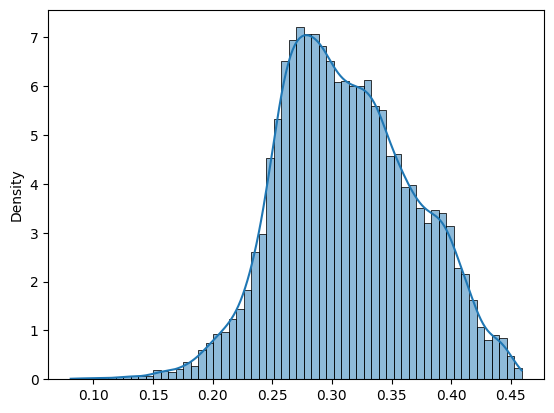

In [13]:
sns.histplot(1 - herg_preds, stat="density", kde=True)

<AxesSubplot: ylabel='Density'>

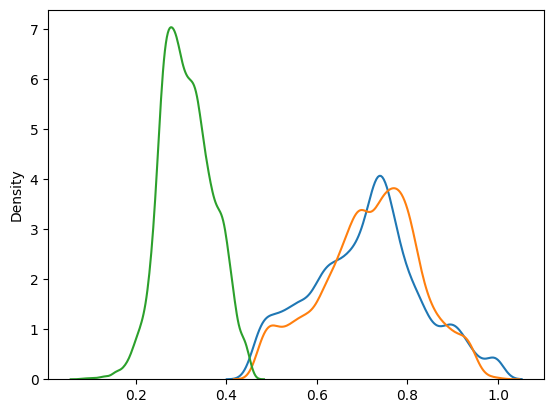

In [14]:
sns.kdeplot(a2ascore_preds)
sns.kdeplot(a1score_preds)
sns.kdeplot(1 - herg_preds)

In [15]:
pd.DataFrame(data={"A2A":a2ascore_preds, "A1":a1score_preds, "hERG":(1-herg_preds)}).to_csv("../data/drugex_selfies_base_80K_scores_deduped.csv", index=False)

In [16]:
a2ascore_preds.reshape(1, -1)

tensor([[0.7018, 0.7541, 0.7308,  ..., 0.6995, 0.7236, 0.5917]])

In [17]:
(1-herg_preds)

tensor([0.2771, 0.3547, 0.2872,  ..., 0.2867, 0.2718, 0.3531])

In [18]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [20]:
df = pd.read_csv("../data/drugex_selfies_base_80K_scores_deduped.csv")

In [21]:
pareto_front = is_pareto_efficient(-df.to_numpy()[1:].astype(float), return_mask=False)

In [22]:
aaa = df.to_numpy()[1:].astype(float)

In [23]:
pf = aaa[pareto_front]

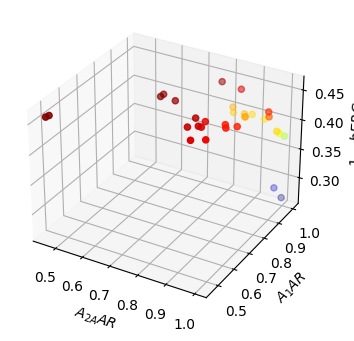

In [24]:
from matplotlib import cm
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")

dfa = pd.DataFrame({'x': pf[:,0], 'y': pf[:,1], 'z': pf[:,2]})
# surf = ax.plot_trisurf(df.x, df.y, df.z, linewidth=0.1, antialiased=True, edgecolor="grey", cmap=cm.jet)
scatter = ax.scatter3D(dfa.x, dfa.y, dfa.z, c=dfa.z, cmap=cm.jet)

In [25]:
pareto_front = is_pareto_efficient(-df.to_numpy()[1:].astype(float), return_mask=False)

In [26]:
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)

In [27]:
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]


In [28]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs
import pandas as pd

In [29]:
from rxitect.scorers.rascore import mol2fcfp, load_rascore_model
fcfps = [mol2fcfp(m) for m in mols]
fcfps = torch.tensor(np.array(fcfps), dtype=torch.float, device="cpu")

In [30]:
ras = load_rascore_model("../models/rascore_26102022.ckpt")
# ras.cpu()
ras_scores = ras(fcfps)

 [*] Loading checkpoint from ../models/rascore_26102022.ckpt succeed!
Checkpoint restored!


In [31]:
from rxitect.scorers.sascore import calculateScore
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [32]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt

In [33]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

Text(0.5, 0, '$1-hERG$')

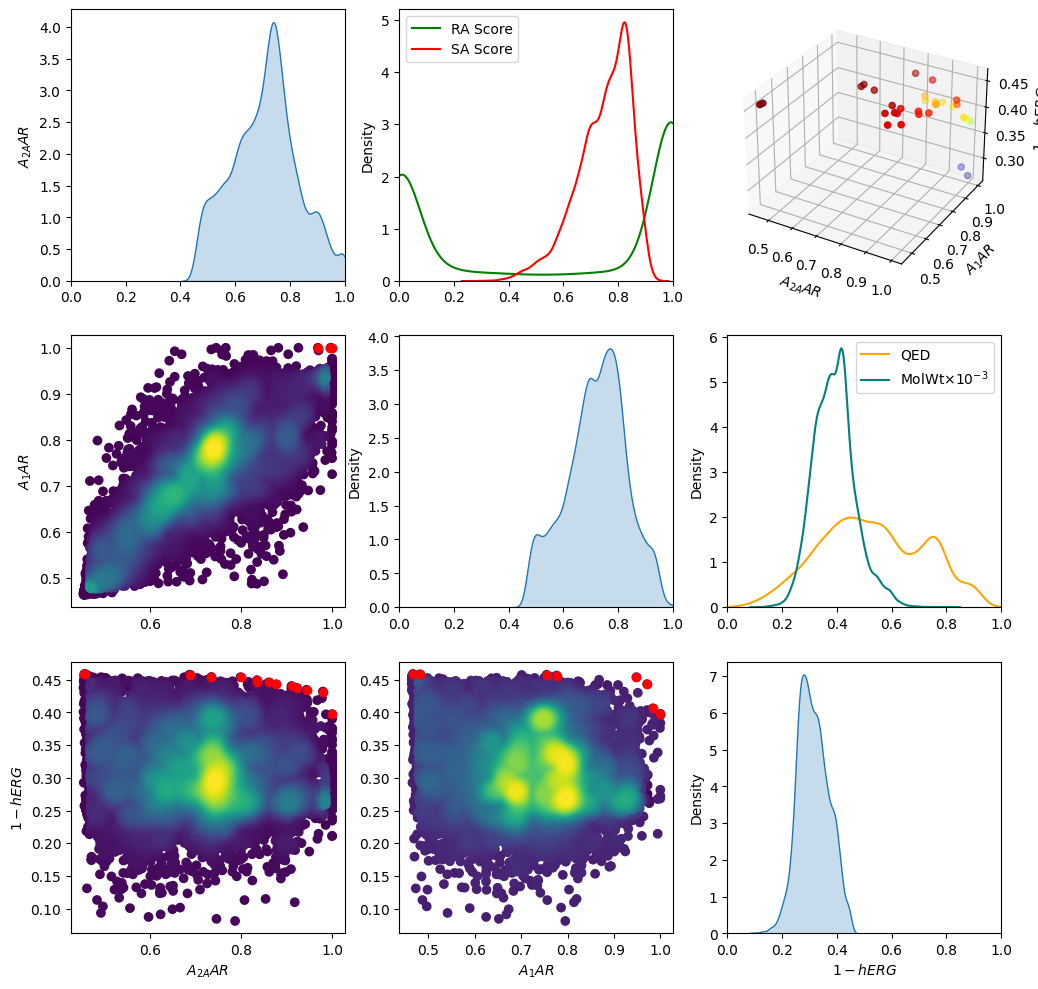

In [36]:
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(a2ascore_preds, ax=ax[0, 0], fill=True)
sns.kdeplot(a1score_preds, ax=ax[1, 1], fill=True)
sns.kdeplot((1-herg_preds), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(dfa.x, dfa.y, dfa.z, c=dfa.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

(0.0, 1.0, 0.0, 1.0)

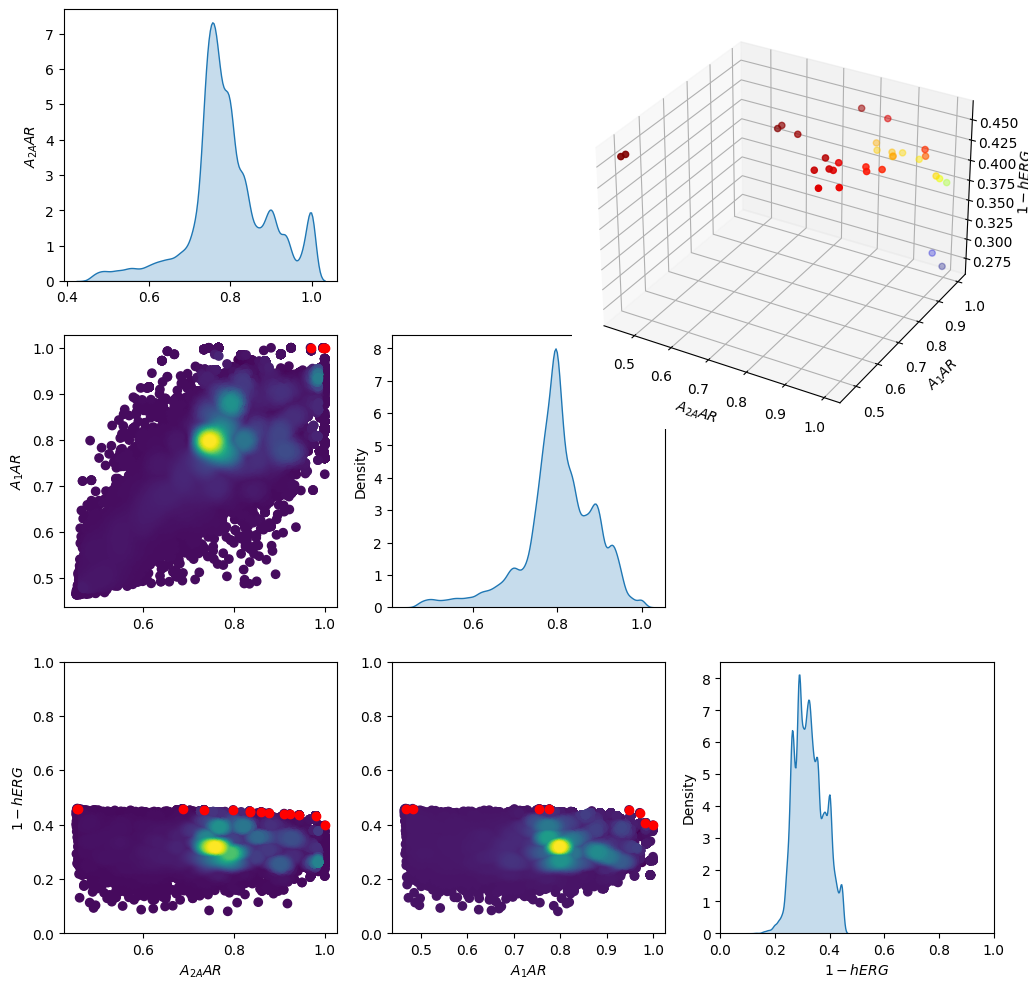

In [236]:
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(a2ascore_preds, ax=ax[0, 0], fill=True)
sns.kdeplot(a1score_preds, ax=ax[1, 1], fill=True)
sns.kdeplot((1-herg_preds), ax=ax[2, 2], fill=True)
ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(2,2,2,projection='3d')
ax[0, 2].scatter3D(dfa.x, dfa.y, dfa.z, c=dfa.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
ax[1, 2].axis('off')


In [37]:
fig.savefig("../reports/drugex_plus_r_base_pareto_dist_pairplot_deduped.png")

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    fig = None
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    if fig:
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
        cbar.ax.set_ylabel('Density')

    return ax

<AxesSubplot: >

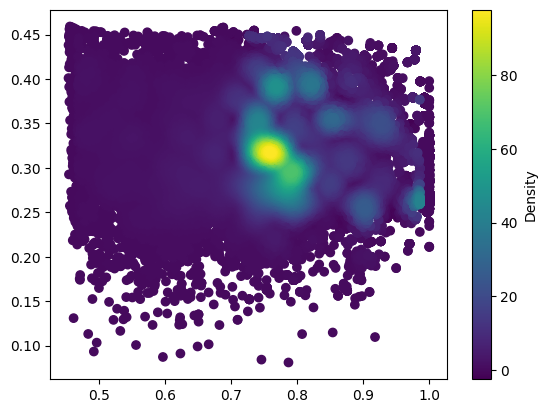

In [186]:
density_scatter(df["A2A"], df["hERG"])